# computing $\pi$ with GPU

The goal of this exercice is to compute an estimate of $\pi$ on the GPU using [Monte Carlo integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration).


This technique consists in generating a number random 2D points with coordinates ranging from 0 to 1.
and then the distance of these points to the origin.
 
The fraction of points falling whithin a distance 1.0 from the origin should approximate $\pi/4$ with an increasing precision as the number of generated points increase.


![](figures/MCpi.png)


### What CPU and GPU am I using?

Before we start, lets check what processor and GPU we will be using. Performance can vary a lot depending on which model we are using. Google Collab does not allow us to choose the model, but it is free.

In [58]:
!echo "CPU:"
!cat /proc/cpuinfo | grep name
!echo "GPU:"
!nvidia-smi

CPU:
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13700K
model name	: 13th Gen Intel(R) Core(TM) i7-13

## CPU implementation

We provide a standard Python implementation for reference.

In [59]:
from numpy.random import seed
from numpy.random import random
from numba import jit,njit,prange,cuda, types, float32

@njit()
def estimate_pi_cpu( nb_points ):
    nb_points_in = 0 # number of points in the circle
    
    for i in range(nb_points):
        pt = random(2) # random 2D coordinates between 0 and 1
        
        dist = (pt**2).sum()**0.5  # distance from the origin
        
        nb_points_in += (dist <= 1.0) # increment if distance is <= 1

    return (nb_points_in / nb_points)*4
    

# a single estimate of pi
estimate_pi_cpu( 10**6 )    

3.143692

The complexity is linear with the number of points generated. 
Therefore here we use a large vector size to increase the execution time. 

In [62]:
# timing the estimate with 2**24 points:
%time pi_estimate = estimate_pi_cpu( 2**24 ) 
print( pi_estimate )

CPU times: user 528 ms, sys: 28 µs, total: 528 ms
Wall time: 528 ms
3.141482353210449


## The CUDA implementation

Now it's your turn to implement the CUDA kernel! 

The main difficulties here reside in the implementation of the random number generation as well as the reduction to the final value. Use the [numba documentation on the topic](https://numba.readthedocs.io/en/stable/cuda/reduction.html) to help you.

In [65]:
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import numpy as np
import math

@cuda.jit
def estimate_pi(states, count):
    idx = cuda.grid(1)

    if idx >= states.size:
        return
        
    # generate a single point and check its distance
    x = cuda.random.xoroshiro128p_uniform_float32(states, idx)
    y = cuda.random.xoroshiro128p_uniform_float32(states, idx)

    if x * x + y * y <= 1.0:
        # handle the reduction
        cuda.atomic.add(count, 0, 1) # count[0] += 1

def estimate_pi_gpu(nb_points):
    blocksize = 128 # block size = number of threads per block dimension
    gridsize = math.ceil(nb_points / blocksize) # grid size = number of blocks per grid dimension
    
    states = create_xoroshiro128p_states(blocksize * gridsize, seed=1)
    
    count = cuda.device_array(1, dtype=np.int32)
    count[0] = 0
    
    estimate_pi[gridsize, blocksize](states, count)
    
    # Copy result back to host
    inside_circle = count.copy_to_host()[0]
    
    # Estimate Pi
    return (4.0 * inside_circle) / nb_points

# Why does it work so well with atomic.add? Is't this an operation that must be executed sequentially by definition???!!
# Yes it is! But modern GPUs are heavily optimized and not all threads will perform this operation simultaneously.
# - only ~78% of the points result in a atomic add
# - Warp-level serialization to avoid intra-warp contention.
# - L2 cache buffering and write combining to reduce direct global memory updates.
# - Memory bank optimizations to avoid bank conflicts.
# - Warp scheduling and parallel execution to hide atomic latency.

Now, time your function:

In [66]:
# calling the function
size = 2**24
%time pi_estimate = estimate_pi_gpu(size)
print(pi_estimate)

CPU times: user 1.8 s, sys: 36.6 ms, total: 1.84 s
Wall time: 1.83 s
CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 30.1 ms
CPU times: user 1.83 s, sys: 36.7 ms, total: 1.87 s
Wall time: 1.87 s
3.1410675048828125


/home/razlock/miniforge3/envs/fit/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


# Problem

We spend >90% of the time creating the 2**24 random states

**Solution:** fix the number of threads.
- We need enough threads to fill the entire GPU
- Compute more points per threads
- Adjust threads_per_block to have enough blocks to fill all the SMs

In [43]:
import numpy as np
from numba import cuda, int32
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32

@cuda.jit
def estimate_pi_kernel(states, pts_per_thread, count):
    idx = cuda.grid(1)  # Global thread index
    
    if idx >= states.size:
        return

    local_count = 0
    for j in range(pts_per_thread):
        # Generate two random numbers in [0,1)
        x = xoroshiro128p_uniform_float32(states, idx)
        y = xoroshiro128p_uniform_float32(states, idx)
        
        # Check if the point is inside the circle
        if x * x + y * y <= 1.0:
            local_count += 1

    count[idx] = local_count

    reduce(count)
    # Atomically add the thread’s count into the global counter
    #cuda.atomic.add(count, 0, local_count)

In [67]:
def estimate_pi_cuda(nb_points):
    # Choose a fixed number of threads that is much smaller than nb_points.
    threads_per_block = 128
    total_threads = 2**14  # A (small) fixed number of states will be created.
    pts_per_thread = nb_points // total_threads  # Points per thread

    # Allocate a one-element array for the global count.
    count = np.array([0], dtype=np.int32)
    d_count = cuda.to_device(count)
    
    # Create one RNG state per thread (only 1024 states here).
    states = create_xoroshiro128p_states(total_threads, seed=1)
    
    # Calculate the number of blocks.
    blocks = total_threads // threads_per_block

    print("total_threads:", total_threads)
    print("threads_per_block:", threads_per_block)
    print("pts_per_thread:", pts_per_thread)
    print("blocks:", blocks)
    
    # Launch the kernel.
    estimate_pi_kernel[blocks, threads_per_block](states, pts_per_thread, d_count)
    
    # Copy the result back and compute pi.
    d_count.copy_to_host(count)
    pi_est = 4.0 * count[0] / (pts_per_thread * total_threads)
    return pi_est

In [68]:
nb_points = 2**24  # 16,777,216 total points
%time pi_estimate = estimate_pi_cuda(nb_points)
print(pi_estimate)

total_threads: 16384
threads_per_block: 128
pts_per_thread: 1024
blocks: 128
CPU times: user 3.16 ms, sys: 16 ms, total: 19.2 ms
Wall time: 18.6 ms
3.142000913619995


# Performance Comparison

In [55]:
import time

# Performance comparison
sizes = [2**i for i in range(10, 29)]
gpu_times = []
cpu_times = []

for size in sizes:
    print("Running: ", size)
    
    # Measure GPU time
    start_gpu = time.time()
    estimate_pi_cuda(size)
    gpu_times.append(time.time() - start_gpu)

    # Measure CPU time
    start_cpu = time.time()
    estimate_pi_cpu(size)
    cpu_times.append(time.time() - start_cpu)

Running:  1024
Running:  2048
Running:  4096
Running:  8192
Running:  16384
Running:  32768
Running:  65536
Running:  131072
Running:  262144
Running:  524288
Running:  1048576
Running:  2097152
Running:  4194304


/tmp/ipykernel_5513/3889723818.py:27: RuntimeWarning: invalid value encountered in scalar divide
  pi_est = 4.0 * count[0] / (pts_per_thread * total_threads)


Running:  8388608
Running:  16777216
Running:  33554432
Running:  67108864
Running:  134217728
Running:  268435456


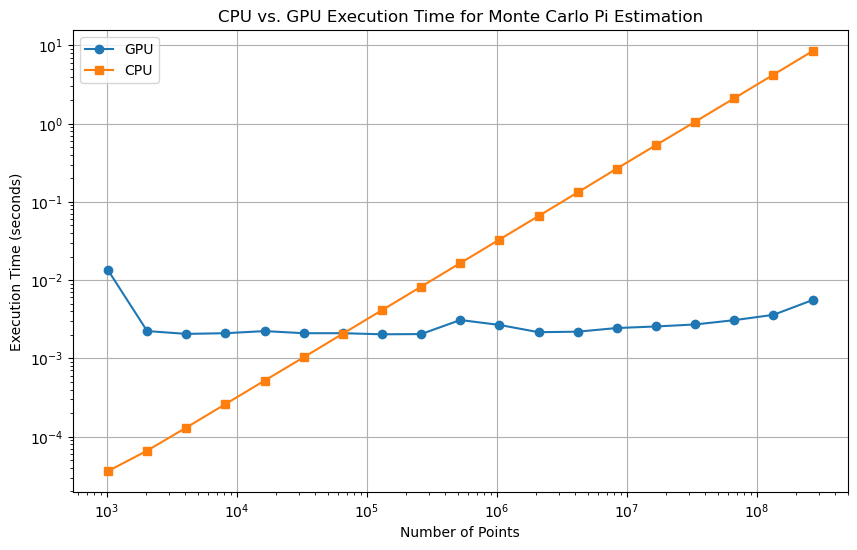

In [69]:
import matplotlib.pyplot as plt

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(sizes, gpu_times, label="GPU", marker='o')
plt.plot(sizes, cpu_times, label="CPU", marker='s')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Points")
plt.ylabel("Execution Time (seconds)")
plt.title("CPU vs. GPU Execution Time for Monte Carlo Pi Estimation")
plt.legend()
plt.grid(True)
plt.show()

# Tentative reduction using shared array: not faster

In [286]:
import numpy as np
from numba import cuda, int32
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32

@cuda.jit
def estimate_pi_kernel_fixed(states, pts_per_thread, count):
    shared = cuda.shared.array(256, int32)
    
    tid = cuda.threadIdx.x  # Thread index within the block
    i = cuda.grid(1)        # Global thread index

    # Each thread's local count of points inside the circle.
    local_count = 0

    # Instead of a grid-stride loop, each thread performs exactly pts_per_thread iterations.
    for j in range(pts_per_thread):
        x = xoroshiro128p_uniform_float32(states, i)
        y = xoroshiro128p_uniform_float32(states, i)
        if x*x + y*y <= 1.0:
            local_count += 1

    # Store the local result in shared memory.
    shared[tid] = local_count
    cuda.syncthreads()

    # Block-level reduction in shared memory.
    stride = cuda.blockDim.x // 2
    while stride > 0:
        if tid < stride:
            shared[tid] += shared[tid + stride]
        cuda.syncthreads()
        stride //= 2

    # The first thread in the block adds the block's total to global_count.
    if tid == 0:
        cuda.atomic.add(count, 0, shared[0])

def estimate_pi_cuda_opt(nb_points):
    threads_per_block = 256
    total_threads = 2**15  # Total number of threads (and RNG states) to create.
    blocks = total_threads // threads_per_block  # e.g., 1024/256 = 4 blocks
    
    # Ensure nb_points divides evenly by total_threads.
    pts_per_thread = nb_points // total_threads

    # Allocate a one-element array on the device for the global count.
    count = np.array([0], dtype=np.int32)
    d_count = cuda.to_device(count)

    # Create a random state per thread.
    states = create_xoroshiro128p_states(total_threads, seed=1)

    print("total_threads:", total_threads)
    print("threads_per_block:", threads_per_block)
    print("pts_per_thread:", pts_per_thread)
    print("blocks:", blocks)

    # Launch the kernel.
    estimate_pi_kernel_fixed[blocks, threads_per_block](states, pts_per_thread, d_count)

    # Copy the result back to host and compute pi.
    d_count.copy_to_host(count)
    return 4.0 * count[0] / nb_points

In [282]:
nb_points = 2**31  # 16,777,216 total points
%time pi_estimate = estimate_pi_cuda_opt(nb_points)
print(pi_estimate)

total_threads: 32768
threads_per_block: 256
pts_per_thread: 65536
blocks: 128
CPU times: user 28.4 ms, sys: 0 ns, total: 28.4 ms
Wall time: 27.9 ms
3.141587231308222
